In [14]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy.special import erf
from sklearn.metrics import f1_score, recall_score, roc_auc_score, average_precision_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import pickle

In [2]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.0.2.


# Defining functions

In [51]:
def encoder_data(df,dfType="700k", experimento=0, n=600000, percentage=0.6,removeDuplicates=False,oneHot=True):
    
    df = df.drop(['time'], axis=1)
    exp = ""
    enc = ""
    num = ""
    dpl = "WithDuplicates"
    
    if(removeDuplicates):
            dpl = "NoDuplicates"
            df = df.drop_duplicates()
            print("Tamanho do dataset retirando duplicatas: " + df.size.astype(str))
    
    separator = int(percentage*len(df))
    
    if(dfType=="700k"):
        df = df.rename(columns={'is_malicious': 'label'})
        features = ['src_user', 'src_comp', 'dst_comp', 'label']

        if(n>df.size):
            num = "allData"
            df_train = df[features][df.label == 0][0:separator]
        else:
            num = n(str)
            df_train = df[features][df.label == 0][0:n]
        
        df_test = df[features][~df[features].dst_comp.isin(df_train.dst_comp.values) & \
                                ~df[features].src_user.isin(df_train.src_user.values)]
        
        y_test = df_test.label.values
    
        df_train = df_train.drop(['label'], axis=1)
        df_test = df_test.drop(['label'], axis=1)

        exp = "B1"
        if(experimento == 1):
            exp = "Exp1"
            df_train = df_train.drop(['src_comp'], axis=1)
            df_test = df_test.drop(['src_comp'], axis=1)
            features.remove('src_comp')
        elif(experimento == 2):
            exp = "Exp2"
            df_train = df_train.drop(['src_user'], axis=1)
            df_test = df_test.drop(['src_user'], axis=1)
            features.remove('src_user')
    
    else:
        num = "allData"
        features = ['computer_source', 'user', 'computer_dest', 'label']

        df_train = df[features][df.label == 0][0:separator]
        df_test = df[features][~df[features].computer_dest.isin(df_train.computer_dest.values) & \
                            ~df[features].user.isin(df_train.user.values)]
        
        y_test = df_test.label.values
        
        df_train = df_train.drop(['label'], axis=1)
        df_test = df_test.drop(['label'], axis=1)
        
        exp = "B2"
        if(experimento == 1):
            exp = "Exp3"
            df_train = df_train.drop(['computer_source'], axis=1)
            df_test = df_test.drop(['computer_source'], axis=1)
            features.remove('computer_source')
        elif(experimento == 2):
            exp = "Exp4"
            df_train = df_train.drop(['user'], axis=1)
            df_test = df_test.drop(['user'], axis=1)
            features.remove('user')
    
    if(oneHot):
        enc = "OneHot"
        fit = OneHotEncoder().fit(df[features[:-1]])
        X_train = fit.transform(df_train.to_numpy()).toarray()
        X_test = fit.transform(df_test.to_numpy()).toarray()
    else:
        enc = "LabelEncoding"
        for col in features[:-1]:
            fit = LabelEncoder().fit(df[col])
            df_train[col] = fit.transform(df_train[col].to_numpy())
            df_test[col] = fit.transform(df_test[col].to_numpy())
        X_train = df_train
        X_test = df_test

    return X_train, X_test, y_test, (exp,(enc,dpl,num))

def get_percentile(scores, y_true):
    out_perc = np.size(np.where(y_true==1)) / len(y_true)
    per = np.percentile(scores, 100 * (1 - out_perc))
    return per

def standardizer(X_train, X_test, type='standard'):
    if type == 'standard':
        scaler = StandardScaler().fit(X_train)
    elif type == 'minmax' or type == 'min_max':
        scaler = MinMaxScaler().fit(X_train)
        
    return scaler.transform(X_train), scaler.transform(X_test)

class Lof(LocalOutlierFactor):
    def fit(self, X_train, y=None):
        self.X_train = X_train
        super().fit(X=X_train, y=y)
        return self

    def decision_function(self, X_test):
        return super().decision_function(X_test)

    def predict_proba(self, X_test):
        nof = self.negative_outlier_factor_ * -1
        test_scores = self.decision_function(X_test) * -1
        scaler = MinMaxScaler().fit(nof.reshape(-1, 1))
        proba = scaler.transform(test_scores.reshape(-1, 1))
        return proba.clip(0, 1)

# Handling datasets

In [4]:
df_700k = pd.read_csv("lanl-comprehensive_700k.csv")

In [5]:
df_700k.head()

,time,src_user,src_comp,dst_comp,is_malicious
0,1.0,ANONYMOUS LOGON@C586,C1250,C586,0
1,1.0,ANONYMOUS LOGON@C586,C586,C586,0
2,1.0,C1021$@DOM1,C1021,C625,0
3,1.0,C1035$@DOM1,C1035,C586,0
4,1.0,C1035$@DOM1,C586,C586,0


In [4]:
df_unified_auth = pd.read_csv("lanl-comprehensive-unified-auth.csv")

In [5]:
df_unified_auth.head()

,time,computer_source,user,computer_dest,label
0,87151,C288750,U451666,C313779,0
1,87451,C288750,U451666,C313779,0
2,100695,C206546,U457678,C639081,0
3,100695,C206546,U457678,C639081,0
4,101274,C206546,U416717,C825721,0


# Encoding and choosing Experiment


In [54]:
X_train, X_test, y_test, res = encoder_data(df_700k,dfType="700k", removeDuplicates=True,oneHot=False)
res

Tamanho do dataset retirando duplicatas: 178080


('B1', ('LabelEncoding', 'NoDuplicates', 'allData'))

In [55]:
X_train_norm, X_test_norm = standardizer(X_train, X_test)

# Train

In [56]:
%%time
model = Lof(n_neighbors=10, novelty= True)
model.fit(X_train_norm)

test_scores = model.predict_proba(X_test_norm)

CPU times: user 363 ms, sys: 3.62 ms, total: 367 ms
Wall time: 630 ms


# Metrics

In [57]:
roc = roc_auc_score(y_test, test_scores)
ap = average_precision_score(y_test, test_scores)

print(f"ROC score: {roc}")
print(f"Average precision score: {ap}")


ROC score: 0.42407766990291257
Average precision score: 0.7650439810334854


In [58]:
per = get_percentile(test_scores, y_test.astype(int))    
y_pred = (test_scores>=per)

roc_score_auc = roc_auc_score(y_test.astype(int), y_pred.astype(int)) 
average_precision = average_precision_score(y_test.astype(int), y_pred.astype(int))

precision, recall, f1, _ = precision_recall_fscore_support(y_test.astype(int),
                                                            y_pred.astype(int),
                                                            average='binary')
print(f"F1 {f1}")
print(f"Recall: {recall}")

F1 0.8917748917748918
Recall: 1.0


In [59]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [60]:
print(f"True positives: {tp}")
print(f"False positives: {fp}")

True positives: 103
False positives: 25


In [61]:
import pickle

metrics = {'F1':f1,'Average Precision':ap,'Recall':recall,'ROC value':roc}
tp_fp = {'tp':tp,'fp':fp}

exp, arq = res
enc,dpl,n = arq

pickle.dump((metrics,tp_fp), open("results/"+exp+"/"+enc+"-"+ dpl +"-"+"N("+n+")"+".pkl", "wb"))

# Graphic representation

In [66]:
def plotarComparação(ress,nomePng):

        experimentos = []

        tps = []
        fps = []
        f1s = []
        recalls = []
        aps = [] 
        rocs =[]

        for res in ress:
                exp, arq = res
                enc,dpl,n = arq
                
                metrics, tp_fp = pickle.load( open( "results/"+exp+"/"+enc+"-"+ dpl +"-"+"N("+n+")"+".pkl", "rb" ) )
                
                experimentos.append(exp+"-"+enc[0]+"-"+dpl[0]+"-"+"("+n+")")
                
                tps.append(tp_fp['tp'])
                fps.append(tp_fp['fp'])
                f1s.append(metrics['F1'])
                recalls.append(metrics['Recall'])
                aps.append(metrics['Average Precision'])
                rocs.append(metrics['ROC value'])

        fig, axs = plt.subplots(1,3,sharex=True,figsize =(18, 7))

        barWidth = 0.25
        br1 = np.arange(len(experimentos))
        br2 = [x + barWidth for x in br1]

        axs.flat[0].bar(br1,tps,color='red',width = barWidth,label="tp")
        axs.flat[0].bar(br2,fps,color='cyan',width = barWidth,label="fp")
        axs.flat[0].set_xticks([r + barWidth for r in range(len(experimentos))],
                experimentos)
        axs.flat[0].legend()

        axs.flat[1].bar(br1,f1s,color='green',width = barWidth,label="F1")
        axs.flat[1].bar(br2,recalls,color='magenta',width = barWidth,label="Recall")
        axs.flat[1].set_xticks([r + barWidth for r in range(len(experimentos))],
                experimentos)
        axs.flat[1].legend()

        axs.flat[2].bar(br1,aps,color='yellow',width = barWidth,label="Average Precision")
        axs.flat[2].bar(br2,rocs,color='blue',width = barWidth,label="ROC score")
        axs.flat[2].set_xticks([r + barWidth for r in range(len(experimentos))],
                experimentos)
        axs.flat[2].legend()

        plt.savefig("comparacoes/"+nomePng+'.png')

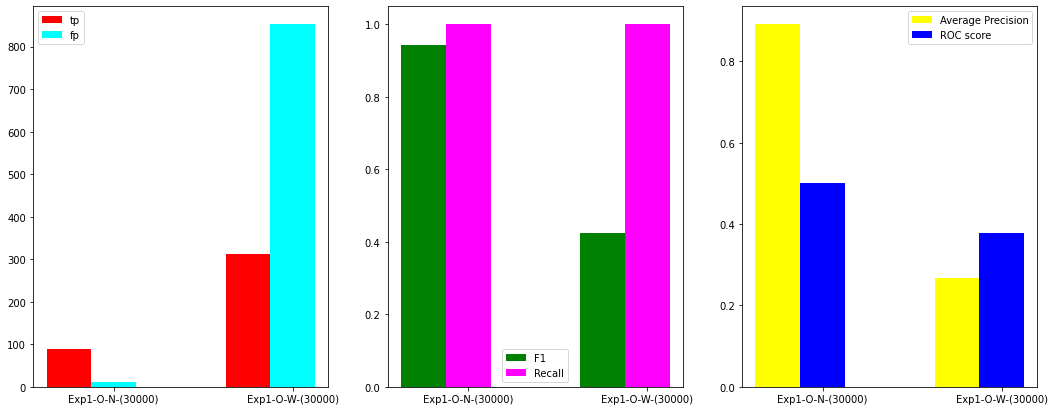

In [65]:
res1 = ("Exp1",("OneHot","NoDuplicates","30000"))
res2 = ("Exp1",("OneHot","WithDuplicates","30000"))

plotarComparação([res1,res2],'Comparacao-com-e-sem-duplicatas-Exp1')

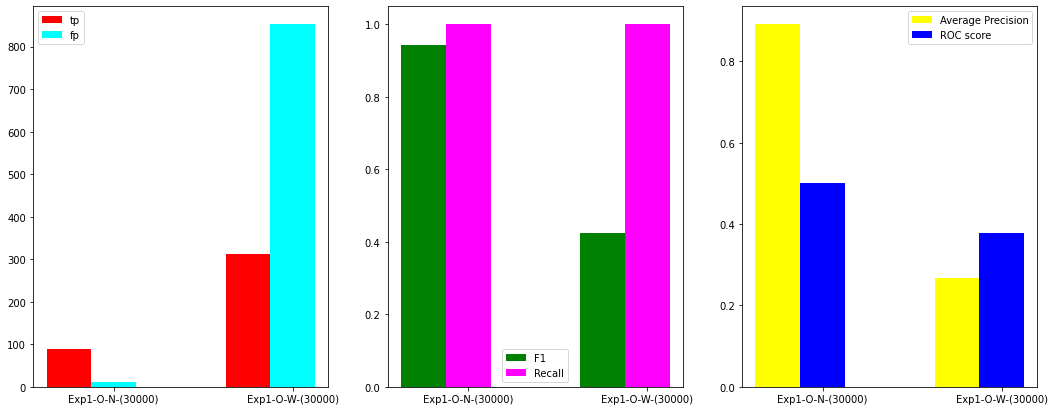

In [67]:
res1 = ("Exp1",("OneHot","NoDuplicates","30000"))
res2 = ("Exp1",("OneHot","WithDuplicates","30000"))

plotarComparação([res1,res2],'Comparacao-com-e-sem-duplicatas-Exp1')

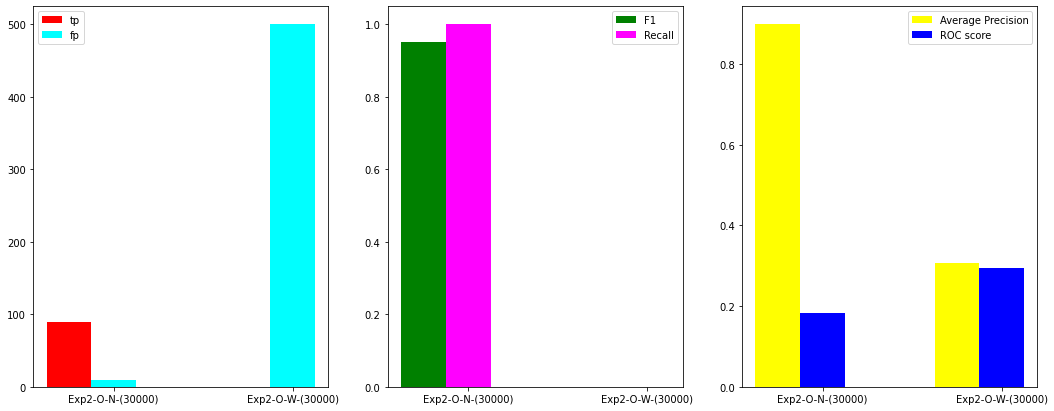

In [68]:
res1 = ("Exp2",("OneHot","NoDuplicates","30000"))
res2 = ("Exp2",("OneHot","WithDuplicates","30000"))

plotarComparação([res1,res2],'Comparacao-com-e-sem-duplicatas-Exp2')

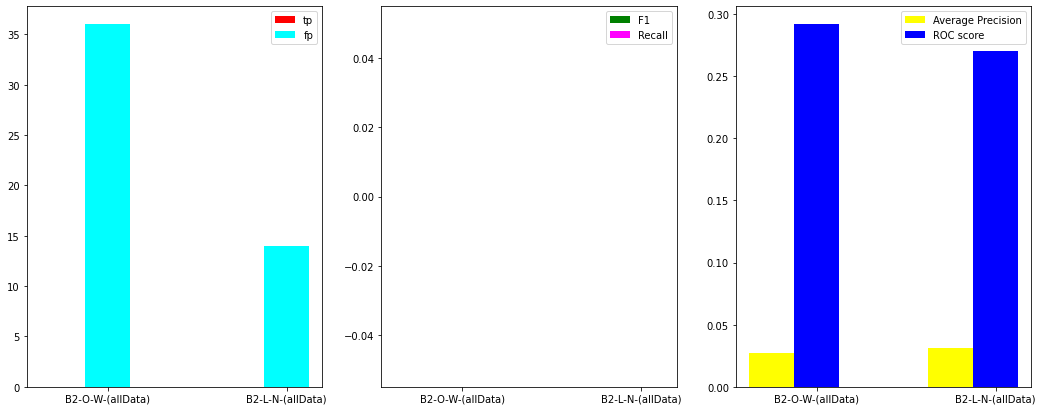

In [69]:
res1 = ("B2",("OneHot","WithDuplicates","allData"))
res2 = ("B2",("LabelEncoding","NoDuplicates","allData"))

plotarComparação([res1,res2],'Comparacao-com-e-sem-label-encoding-B2')

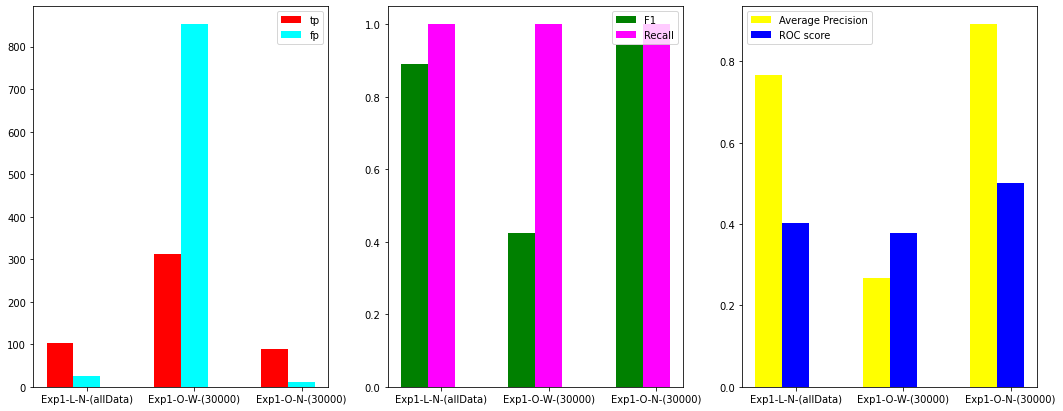

In [70]:
res1 = ("Exp1",("LabelEncoding","NoDuplicates","allData"))
res2 = ("Exp1",("OneHot","WithDuplicates","30000"))
res3 = ("Exp1",("OneHot","NoDuplicates","30000"))

plotarComparação([res1,res2,res3],"Comparacao-labelEncoding(sem-duplicata)-vs-OneHot(com-e-sem-duplicata)-Exp1")

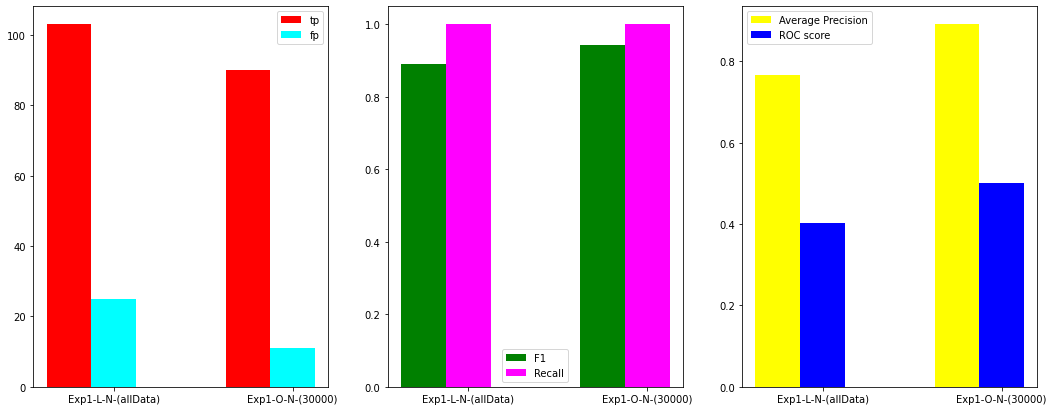

In [71]:
res1 = ("Exp1",("LabelEncoding","NoDuplicates","allData"))
res2 = ("Exp1",("OneHot","NoDuplicates","30000"))

plotarComparação([res1,res2],"Comparacao-LabelEncoding-vs-OneHotEncoding-Exp1")